Inspired in: https://playground.tensorflow.org/

In [1]:
using Pkg
Pkg.activate("..")

  Activating environment at `E:\Projects\OCDNN.jl\Project.toml`


In [2]:
using Revise
using OCDNN, Printf, Random, Serialization, Plots

┌ Info: Precompiling OCDNN [04e95dd8-2660-4c0e-9d70-3f4d10bb3a0d]
└ @ Base loading.jl:1342


In [3]:
using Base.Threads

In [4]:
gr()

Plots.GRBackend()

In [5]:
function in_dir(f, path::String)
    current = pwd()
    cd(path)
    f()
    cd(current)
end

in_dir (generic function with 1 method)

In [6]:
Random.seed!(1234)
dataset = build_dataset(N_samples = 50, N_noise = 5);
data, feat = dataset;

In [7]:
N,d = size(data);

In [8]:
idxs = feat .== 1;

In [9]:
Cs = get_color_palette(:tab10, plot_color(:white));

In [10]:
xs = collect(0:0.01:1)
ys = collect(0:0.01:1);

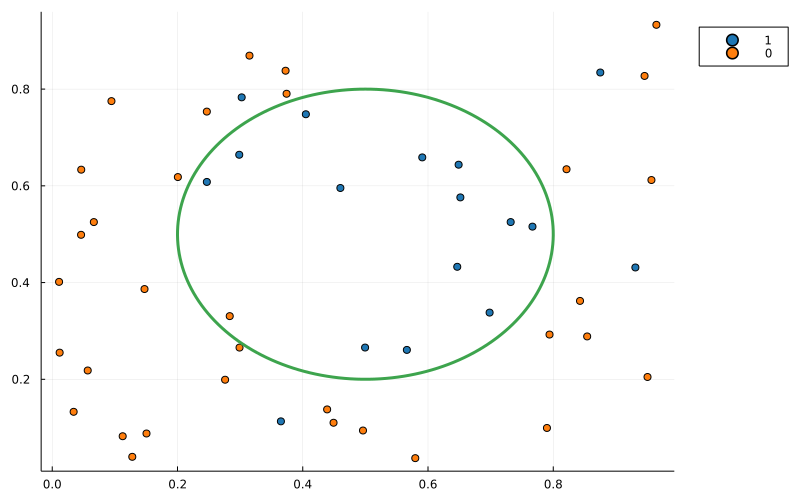

In [11]:
p = Plots.plot(size= (800,500), legend = :outertopright)
Plots.scatter!(p,data[:,1][idxs],data[:,2][idxs], label = "1", c = Cs[1])
Plots.scatter!(p,data[:,1][.!idxs],data[:,2][.!idxs], label = "0", c = Cs[2])
Plots.plot!(p, t->0.3sin(t)+0.5,t->0.3cos(t)+0.5, 0, 2pi, label=false, linewidth=3)

In [12]:
nlayers = 24
channels = 24 # number of neurons per layer
niter = 2000
τ=0.1;
τ_max=10;
hs = [10, 1, 0.1, 0.01];
stepsize = 0.1
c = Int(nlayers/nthreads())

24

In [13]:
rks = [RK1,RK2,RK3,RK4];

In [14]:
names = [rk.name for rk in rks];

In [15]:
eta = x -> exp(x)/(exp(x)+1)

#7 (generic function with 1 method)

In [16]:
problem = Problem(tanh, eta, feat);

In [17]:
function cb(iter, rkmethod, nlayers, α, log, Ctrls)
    period = 500
    if rem(iter,period) == 0 || iter == 1
        @printf("\nMethod=%s, nlayers=%d, channels=%d\n",rkmethod.name,nlayers,Ctrls.channels)
        @printf("Iteration no: %d\n",iter)
        @printf("Value of alpha: %7.4f\n",α);
        @printf("Residual: %8.4f\n",log.loss[end])
        @printf("Norm Grad: %8.4e\n",log.grad_norm[end]);
        @printf("Accuracy: %8.4f %% \n",log.accuracy[end]*100);
        if iter > 1
            @printf("Time: %8.4f\n",sum(log.time[end-period+1:end]));
        end
    end
end

cb (generic function with 1 method)

In [18]:
result = train_ode_dnn(dataset, nlayers, channels, RK1, niter, τ, τ_max, stepsize, problem, cb, c, true);


Method=Euler, nlayers=24, channels=24
Iteration no: 1
Value of alpha:  0.0500
Residual:  14.5711
Norm Grad: 1.8480e+00
Accuracy:  36.0000 % 

Method=Euler, nlayers=24, channels=24
Iteration no: 500
Value of alpha:  0.0125
Residual:   2.1869
Norm Grad: 1.8689e-01
Accuracy:  88.0000 % 
Time:   8.3531

Method=Euler, nlayers=24, channels=24
Iteration no: 1000
Value of alpha:  0.0125
Residual:   1.9347
Norm Grad: 1.2587e-01
Accuracy:  90.0000 % 
Time:   4.9506

Method=Euler, nlayers=24, channels=24
Iteration no: 1500
Value of alpha:  0.0125
Residual:   1.7741
Norm Grad: 1.2507e-01
Accuracy:  90.0000 % 
Time:   4.8356

Method=Euler, nlayers=24, channels=24
Iteration no: 2000
Value of alpha:  0.0125
Residual:   1.5841
Norm Grad: 1.4530e-01
Accuracy:  90.0000 % 
Time:   4.7882


In [19]:
result_fwd = train_ode_dnn(dataset, nlayers, channels, RK1, niter, τ, τ_max, stepsize, problem, cb, nlayers, false);


Method=Euler, nlayers=24, channels=24
Iteration no: 1
Value of alpha:  0.0500
Residual:   9.5124
Norm Grad: 5.1421e+00
Accuracy:  52.0000 % 

Method=Euler, nlayers=24, channels=24
Iteration no: 500
Value of alpha:  0.0250
Residual:   1.8592
Norm Grad: 1.6048e-01
Accuracy:  90.0000 % 
Time:   2.4529

Method=Euler, nlayers=24, channels=24
Iteration no: 1000
Value of alpha:  0.0250
Residual:   1.3926
Norm Grad: 2.2891e-01
Accuracy:  92.0000 % 
Time:   2.4105

Method=Euler, nlayers=24, channels=24
Iteration no: 1500
Value of alpha:  0.0125
Residual:   0.9375
Norm Grad: 2.0508e-01
Accuracy:  96.0000 % 
Time:   2.4030

Method=Euler, nlayers=24, channels=24
Iteration no: 2000
Value of alpha:  0.0125
Residual:   0.7143
Norm Grad: 1.7495e-01
Accuracy:  96.0000 % 
Time:   2.3855


In [20]:
cd("E:\\Projects\\OCDNN.jl\\notebooks")

In [21]:
final_string = string(nlayers)*"_layers_"*string(N)*"_points_"*string(channels)*"_channels"
outputdir = "..\\images_Parallel\\Classification\\"*final_string
if !ispath(outputdir)
    mkpath(outputdir)
end

In [22]:
Ctrls_fwd,logs_fwd = result_fwd;

In [23]:
Ctrls,logs = result;

In [24]:
names = [RK1.name]

1-element Vector{String}:
 "Euler"

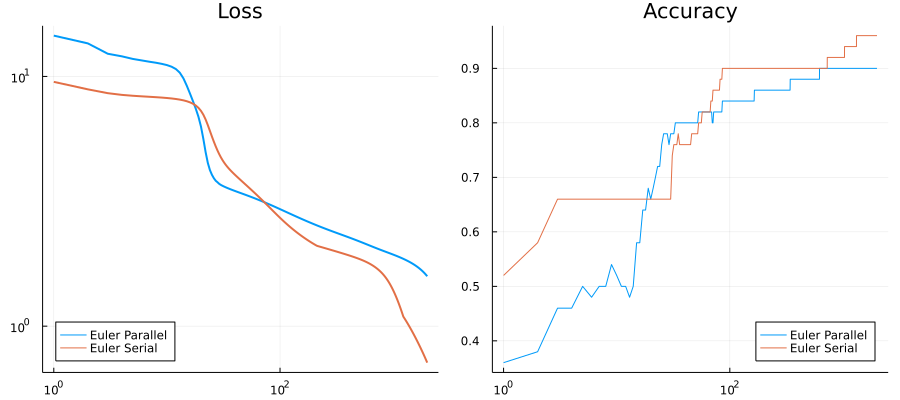

In [25]:
p1 = Plots.plot(logs.loss, xaxis = :log10, yaxis = :log10, label = "Euler Parallel", linewidth=2, legend= :bottomleft)
p2 = Plots.plot(logs.accuracy, xaxis = :log10, label = "Euler Parallel", legend= :bottomright)
p1 = Plots.plot(p1,logs_fwd.loss, xaxis = :log10, yaxis = :log10, label = "Euler Serial", linewidth=2, legend= :bottomleft)
p2 = Plots.plot(p2,logs_fwd.accuracy, xaxis = :log10, label = "Euler Serial", legend= :bottomright)
Plots.plot(p1,p2, title = ["Loss" "Accuracy"], size = (900,400))

In [26]:
in_dir(outputdir) do
    Plots.savefig("loss_acc_euler_"*final_string*".pdf")
end

In [27]:
all_times = [sum(logs.time),sum(logs_fwd.time)];
labels = ["Parallel","Serial"]

2-element Vector{String}:
 "Parallel"
 "Serial"

In [28]:
CS = get_color_palette(:auto, plot_color(:white))
all_cs = [CS[i] for i in 1:2];

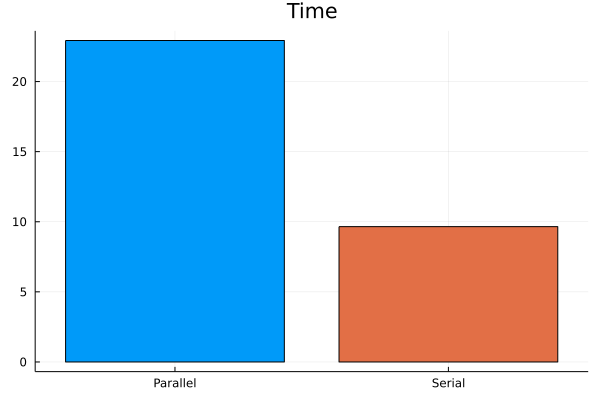

In [29]:
Plots.bar(all_times, xticks = (1:2,labels), title = "Time", legend = :none, fillcolor = all_cs)

In [30]:
in_dir(outputdir) do
    Plots.savefig("time_euler_"*final_string*".pdf")
end

In [31]:
Ctrls_test = deepcopy(Ctrls);
Ctrls_test_fwd = deepcopy(Ctrls_fwd);

In [32]:
xs = collect(0:0.002:1)
ys = collect(0:0.002:1);

In [33]:
Y0_test = [[x,y] for x in xs, y in ys];

In [34]:
Ctrls_test.Y0 = hcat(Y0_test...)';
Ctrls_test_fwd.Y0 = hcat(Y0_test...)';

In [35]:
classifier_fwd = OCDNN.RKforwardstepper(Ctrls_test_fwd,RK1,problem).Classifier;

In [36]:
classifier = OCDNN.MGRITforwardstepper(Ctrls_test,RK1,problem,c).Classifier;

In [37]:
values = reshape(round.(classifier), size(Y0_test))';
values_fwd = reshape(round.(classifier_fwd), size(Y0_test))';

In [38]:
Cs1 = get_color_palette(:tab10, plot_color(:white));

In [39]:
names = ["Serial","Parallel"]

2-element Vector{String}:
 "Serial"
 "Parallel"

In [40]:
value = [values_fwd,values];

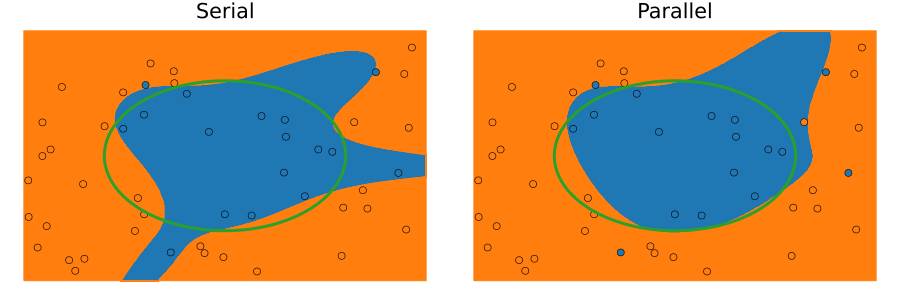

In [41]:
p = []
for i in 1:2
    pi = Plots.plot(title = names[i], legend = :none, axis = false, ticks = false)
    Plots.contour!(pi,xs,ys, value[i], fill = true, c = [Cs1[2],Cs1[1]])
    Plots.scatter!(pi,data[:,1][idxs],data[:,2][idxs], c = Cs1[1])
    Plots.scatter!(pi,data[:,1][.!idxs],data[:,2][.!idxs], c = Cs1[2])
    Plots.plot!(pi, t->0.3sin(t)+0.5,t->0.3cos(t)+0.5, 0, 2π, legend=false, linewidth=3, c = Cs1[3])
    push!(p,pi)
end
Plots.plot(p..., size=(900,300))

In [42]:
in_dir(outputdir) do
    Plots.savefig("Contour_euler_"*final_string*".pdf")
end